In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import math
from functools import partial
from distutils.version import LooseVersion
from einops import repeat

In [2]:
class EncoderLayer(nn.Module):
    """
    Represents one Encoder layer of the Transformer Encoder
    Refer Fig. 1 in https://arxiv.org/pdf/1706.03762.pdf
    NOTE: The layer normalization step has been moved to the input as per latest version of T2T
    """
    def __init__(self, hidden_size, total_key_depth, total_value_depth, filter_size, num_heads,
                 bias_mask=None, layer_dropout=0.0, attention_dropout=0.0, relu_dropout=0.0):
        """
        Parameters:
            hidden_size: Hidden size
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            num_heads: Number of attention heads
            bias_mask: Masking tensor to prevent connections to future elements
            layer_dropout: Dropout for this layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
        """
        
        super(EncoderLayer, self).__init__()
        
        self.multi_head_attention = MultiHeadAttention(hidden_size, total_key_depth, total_value_depth, 
                                                       hidden_size, num_heads, bias_mask, attention_dropout)
        
        self.positionwise_feed_forward = PositionwiseFeedForward(hidden_size, filter_size, hidden_size,
                                                                 layer_config='ll', padding = 'both', 
                                                                 dropout=relu_dropout)
        self.dropout = nn.Dropout(layer_dropout)
        self.layer_norm_mha = LayerNorm(hidden_size)
        self.layer_norm_ffn = LayerNorm(hidden_size)
        
    def forward(self, inputs):
        x = inputs
        
        # Layer Normalization
        x_norm = self.layer_norm_mha(x)
        
        # Multi-head attention
        y = self.multi_head_attention(x_norm, x_norm, x_norm)
        
        # Dropout and residual
        x = self.dropout(x + y)
        
        # Layer Normalization
        x_norm = self.layer_norm_ffn(x)
        
        # Positionwise Feedforward
        y = self.positionwise_feed_forward(x_norm)
        
        # Dropout and residual
        y = self.dropout(x + y)
        
        return y

In [3]:
class DecoderLayer(nn.Module):
    """
    Represents one Decoder layer of the Transformer Decoder
    Refer Fig. 1 in https://arxiv.org/pdf/1706.03762.pdf
    NOTE: The layer normalization step has been moved to the input as per latest version of T2T
    """
    def __init__(self, hidden_size, total_key_depth, total_value_depth, filter_size, num_heads,
                 bias_mask, layer_dropout=0.0, attention_dropout=0.0, relu_dropout=0.0):
        """
        Parameters:
            hidden_size: Hidden size
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            num_heads: Number of attention heads
            bias_mask: Masking tensor to prevent connections to future elements
            layer_dropout: Dropout for this layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
        """
        
        super(DecoderLayer, self).__init__()
        
        self.multi_head_attention_dec = MultiHeadAttention(hidden_size, total_key_depth, total_value_depth, 
                                                       hidden_size, num_heads, bias_mask, attention_dropout)

        self.multi_head_attention_enc_dec = FastAttention(dim_heads=hidden_size, nb_features=21)
       
        self.positionwise_feed_forward = PositionwiseFeedForward(hidden_size, filter_size, hidden_size,
                                                                 layer_config='ll', padding = 'left', 
                                                                 dropout=relu_dropout)
        self.dropout = nn.Dropout(layer_dropout)
        self.layer_norm_mha_dec = LayerNorm(hidden_size)
        self.layer_norm_mha_enc = LayerNorm(hidden_size)
        self.layer_norm_ffn = LayerNorm(hidden_size)

        
    def forward(self, inputs):
        """
        NOTE: Inputs is a tuple consisting of decoder inputs and encoder output
        """
        x, encoder_outputs = inputs
        
        # Layer Normalization before decoder self attention
        x_norm = self.layer_norm_mha_dec(x)
        
        # Masked Multi-head attention
        y = self.multi_head_attention_dec(x_norm, x_norm, x_norm)
        
        # Dropout and residual after self-attention
        x = self.dropout(x + y)

        # Layer Normalization before encoder-decoder attention
        x_norm = self.layer_norm_mha_enc(x)

        # Multi-head encoder-decoder attention
        y = self.multi_head_attention_enc_dec(q=x_norm, k=encoder_outputs, v=encoder_outputs)
        
        # Dropout and residual after encoder-decoder attention
        x = self.dropout(x + y)
        
        # Layer Normalization
        x_norm = self.layer_norm_ffn(x)
        
        # Positionwise Feedforward
        y = self.positionwise_feed_forward(x_norm)
        
        # Dropout and residual after positionwise feed forward layer
        y = self.dropout(x + y)
        
        # Return encoder outputs as well to work with nn.Sequential
        return y, encoder_outputs

In [4]:
TORCH_GE_1_8_0 = LooseVersion(torch.__version__) >= LooseVersion('1.8.0')

def default(val, d):
    return val if exists(val) else d

def exists(val):
    return val is not None

def gaussian_orthogonal_random_matrix(nb_rows, nb_columns, scaling = 0, device = None):
    nb_full_blocks = int(nb_rows / nb_columns)

    block_list = []

    for _ in range(nb_full_blocks):
        q = orthogonal_matrix_chunk(nb_columns, device = device)
        block_list.append(q)

    remaining_rows = nb_rows - nb_full_blocks * nb_columns
    if remaining_rows > 0:
        q = orthogonal_matrix_chunk(nb_columns, device = device)
        block_list.append(q[:remaining_rows])

    final_matrix = torch.cat(block_list)

    if scaling == 0:
        multiplier = torch.randn((nb_rows, nb_columns), device = device).norm(dim = 1)
    elif scaling == 1:
        multiplier = math.sqrt((float(nb_columns))) * torch.ones((nb_rows,), device = device)
    else:
        raise ValueError(f'Invalid scaling {scaling}')

    return torch.diag(multiplier) @ final_matrix

def orthogonal_matrix_chunk(cols, device = None):
    unstructured_block = torch.randn((cols, cols), device = device)
    if TORCH_GE_1_8_0:
        q, r = torch.linalg.qr(unstructured_block.cpu(), mode = 'reduced')
    else:
        q, r = torch.qr(unstructured_block.cpu(), some = True)
    q, r = map(lambda t: t.to(device), (q, r))
    return q.t()

def softmax_kernel(data, *, projection_matrix, is_query, normalize_data=True, eps=1e-4, device = None):
    b, h, *_ = data.shape

    data_normalizer = (data.shape[-1] ** -0.25) if normalize_data else 1.

    ratio = (projection_matrix.shape[0] ** -0.5)

    projection = repeat(projection_matrix, 'j d -> b h j d', b = b, h = h)
    projection = projection.type_as(data)

    data_dash = torch.einsum('bid,bijd->bij', (data_normalizer * data), projection)

    diag_data = data ** 2
    diag_data = torch.sum(diag_data, dim=-1)
    diag_data = (diag_data / 2.0) * (data_normalizer ** 2)
    diag_data = diag_data.unsqueeze(dim=-1)

    if is_query:
        data_dash = ratio * (
            torch.exp(data_dash - diag_data -
                    torch.amax(data_dash, dim=-1, keepdim=True).detach()) + eps)
    else:
        data_dash = ratio * (
            torch.exp(data_dash - diag_data - torch.amax(data_dash, dim=(-1, -2), keepdim=True).detach()) + eps)

    return data_dash.type_as(data)

def linear_attention(q, k, v):
    k_cumsum = k.sum(dim = -2)
    D_inv = 1. / torch.einsum('...nd,...d->...n', q, k_cumsum.type_as(q))
    context = torch.einsum('...nd,...ne->...de', k, v)
    out = torch.einsum('...de,...nd,...n->...ne', context, q, D_inv)
    return out

In [5]:
class FastAttention(nn.Module):
    def __init__(self, dim_heads, nb_features = None, ortho_scaling = 0, causal = False, generalized_attention = False, kernel_fn = nn.ReLU(), no_projection = False):
        super().__init__()
        nb_features = default(nb_features, int(dim_heads * math.log(dim_heads)))

        self.dim_heads = dim_heads
        self.nb_features = nb_features
        self.ortho_scaling = ortho_scaling

        self.create_projection = partial(gaussian_orthogonal_random_matrix, nb_rows = self.nb_features, nb_columns = dim_heads, scaling = ortho_scaling)
        projection_matrix = self.create_projection()
        self.register_buffer('projection_matrix', projection_matrix)

        self.generalized_attention = generalized_attention
        self.kernel_fn = kernel_fn

        # if this is turned on, no projection will be used
        # queries and keys will be softmax-ed as in the original efficient attention paper
        self.no_projection = no_projection

        self.causal = causal
        if causal:
            try:
                import fast_transformers.causal_product.causal_product_cuda
                self.causal_linear_fn = partial(causal_linear_attention)
            except ImportError:
                print('unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version')
                self.causal_linear_fn = causal_linear_attention_noncuda

    @torch.no_grad()
    def redraw_projection_matrix(self, device):
        projections = self.create_projection(device = device)
        self.projection_matrix.copy_(projections)
        del projections

    def forward(self, q, k, v):
        device = q.device

        if self.no_projection:
            q = q.softmax(dim = -1)
            k = torch.exp(k) if self.causal else k.softmax(dim = -2)

        elif self.generalized_attention:
            create_kernel = partial(generalized_kernel, kernel_fn = self.kernel_fn, projection_matrix = self.projection_matrix, device = device)
            q, k = map(create_kernel, (q, k))

        else:
            create_kernel = partial(softmax_kernel, projection_matrix = self.projection_matrix, device = device)
            q = create_kernel(q, is_query = True)
            k = create_kernel(k, is_query = False)

        attn_fn = linear_attention if not self.causal else self.causal_linear_fn
        out = attn_fn(q, k, v)
        return out

In [6]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention as per https://arxiv.org/pdf/1706.03762.pdf
    Refer Figure 2
    """
    def __init__(self, input_depth, total_key_depth, total_value_depth, output_depth, 
                 num_heads, bias_mask=None, dropout=0.0):
        """
        Parameters:
            input_depth: Size of last dimension of input
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            num_heads: Number of attention heads
            bias_mask: Masking tensor to prevent connections to future elements
            dropout: Dropout probability (Should be non-zero only during training)
        """
        super(MultiHeadAttention, self).__init__()
        # Checks borrowed from 
        # https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/layers/common_attention.py
        if total_key_depth % num_heads != 0:
            raise ValueError("Key depth (%d) must be divisible by the number of "
                             "attention heads (%d)." % (total_key_depth, num_heads))
        if total_value_depth % num_heads != 0:
            raise ValueError("Value depth (%d) must be divisible by the number of "
                             "attention heads (%d)." % (total_value_depth, num_heads))
            
        self.num_heads = num_heads
        self.query_scale = (total_key_depth//num_heads)**-0.5
        self.bias_mask = bias_mask
        
        # Key and query depth will be same
        self.query_linear = nn.Linear(input_depth, total_key_depth, bias=False)
        self.key_linear = nn.Linear(input_depth, total_key_depth, bias=False)
        self.value_linear = nn.Linear(input_depth, total_value_depth, bias=False)
        self.output_linear = nn.Linear(total_value_depth, output_depth, bias=False)
        
        self.dropout = nn.Dropout(dropout)
    
    def _split_heads(self, x):
        """
        Split x such to add an extra num_heads dimension
        Input:
            x: a Tensor with shape [batch_size, seq_length, depth]
        Returns:
            A Tensor with shape [batch_size, num_heads, seq_length, depth/num_heads]
        """
        if len(x.shape) != 3:
            raise ValueError("x must have rank 3")
        shape = x.shape
        return x.view(shape[0], shape[1], self.num_heads, shape[2]//self.num_heads).permute(0, 2, 1, 3)
    
    def _merge_heads(self, x):
        """
        Merge the extra num_heads into the last dimension
        Input:
            x: a Tensor with shape [batch_size, num_heads, seq_length, depth/num_heads]
        Returns:
            A Tensor with shape [batch_size, seq_length, depth]
        """
        if len(x.shape) != 4:
            raise ValueError("x must have rank 4")
        shape = x.shape
        return x.permute(0, 2, 1, 3).contiguous().view(shape[0], shape[2], shape[3]*self.num_heads)
        
    def forward(self, queries, keys, values, src_mask=None):
        
        # Do a linear for each component
        queries = self.query_linear(queries)
        keys = self.key_linear(keys)
        values = self.value_linear(values)
        
        # Split into multiple heads
        queries = self._split_heads(queries)
        keys = self._split_heads(keys)
        values = self._split_heads(values)
        
        # Scale queries
        queries *= self.query_scale
        
        # Combine queries and keys
        logits = torch.matmul(queries, keys.permute(0, 1, 3, 2))
        

        if src_mask is not None:
            logits = logits.masked_fill(src_mask, -np.inf)
            
        # Add bias to mask future values
        if self.bias_mask is not None:
            logits += self.bias_mask[:, :, :logits.shape[-2], :logits.shape[-1]].type_as(logits.data)
        
        # Convert to probabilites
        weights = nn.functional.softmax(logits, dim=-1)
        
        # Dropout
        weights = self.dropout(weights)
        
        # Combine with values to get context
        contexts = torch.matmul(weights, values)
        
        # Merge heads
        contexts = self._merge_heads(contexts)
        #contexts = torch.tanh(contexts)
        
        # Linear to get output
        outputs = self.output_linear(contexts)
        
        return outputs

In [7]:
class PositionwiseFeedForward(nn.Module):
    """
    Does a Linear + RELU + Linear on each of the timesteps
    """
    def __init__(self, input_depth, filter_size, output_depth, layer_config='ll', padding='left', dropout=0.0):
        """
        Parameters:
            input_depth: Size of last dimension of input
            filter_size: Hidden size of the middle layer
            output_depth: Size last dimension of the final output
            layer_config: ll -> linear + ReLU + linear
                          cc -> conv + ReLU + conv etc.
            padding: left -> pad on the left side (to mask future data), 
                     both -> pad on both sides
            dropout: Dropout probability (Should be non-zero only during training)
        """
        super(PositionwiseFeedForward, self).__init__()
        
        layers = []
        sizes = ([(input_depth, filter_size)] + 
                 [(filter_size, filter_size)]*(len(layer_config)-2) + 
                 [(filter_size, output_depth)])

        for lc, s in zip(list(layer_config), sizes):
            if lc == 'l':
                layers.append(nn.Linear(*s))
            else:
                raise ValueError("Unknown layer type {}".format(lc))

        self.layers = nn.ModuleList(layers)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, inputs):
        x = inputs
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers):
                x = self.relu(x)
                x = self.dropout(x)

        return x


In [8]:
class LayerNorm(nn.Module):
    # Borrowed from jekbradbury
    # https://github.com/pytorch/pytorch/issues/1959
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


In [9]:
def _gen_bias_mask(max_length):
    """
    Generates bias values (-Inf) to mask future timesteps during attention
    """
    np_mask = np.triu(np.full([max_length, max_length], -np.inf), 1)
    torch_mask = torch.from_numpy(np_mask).type(torch.FloatTensor)
    
    return torch_mask.unsqueeze(0).unsqueeze(1)

In [10]:
def _gen_timing_signal(length, channels, min_timescale=1.0, max_timescale=1.0e4):
    """
    Generates a [1, length, channels] timing signal consisting of sinusoids
    Adapted from:
    https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/layers/common_attention.py
    """
    position = np.arange(length)
    num_timescales = channels // 2
    log_timescale_increment = ( math.log(float(max_timescale) / float(min_timescale)) / (float(num_timescales) - 1))
    inv_timescales = min_timescale * np.exp(np.arange(num_timescales).astype(np.float) * -log_timescale_increment)
    scaled_time = np.expand_dims(position, 1) * np.expand_dims(inv_timescales, 0)

    signal = np.concatenate([np.sin(scaled_time), np.cos(scaled_time)], axis=1)
    signal = np.pad(signal, [[0, 0], [0, channels % 2]], 
                    'constant', constant_values=[0.0, 0.0])
    signal =  signal.reshape([1, length, channels])

    return torch.from_numpy(signal).type(torch.FloatTensor)

In [11]:
class Encoder(nn.Module):
    """
    A Transformer Encoder module. 
    Inputs should be in the shape [batch_size, length, hidden_size]
    Outputs will have the shape [batch_size, length, hidden_size]
    Refer Fig.1 in https://arxiv.org/pdf/1706.03762.pdf
    """
    def __init__(self, hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                 filter_size, max_length=100, input_dropout=0.0, layer_dropout=0.0, 
                 attention_dropout=0.0, relu_dropout=0.0, use_mask=False):
        """
        Parameters:
            hidden_size: Hidden size
            num_layers: Total layers in the Encoder
            num_heads: Number of attention heads
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            max_length: Max sequence length (required for timing signal)
            input_dropout: Dropout just after embedding
            layer_dropout: Dropout for each layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
            use_mask: Set to True to turn on future value masking
        """
        
        super(Encoder, self).__init__()
        
        self.position_signal = _gen_timing_signal(num_layers, hidden_size)

        self.num_layers = num_layers
        
        self.encs = nn.ModuleList(
            [
                EncoderLayer(
                    hidden_size, 
                    total_key_depth or hidden_size,
                    total_value_depth or hidden_size,
                    filter_size, 
                    num_heads, 
                    _gen_bias_mask(max_length) if use_mask else None,
                    layer_dropout, 
                    attention_dropout, 
                    relu_dropout
                )
                for _ in range(num_layers)
            ]
        )
        
        self.layer_norm = LayerNorm(hidden_size)
        self.input_dropout = nn.Dropout(input_dropout)

    def forward(self, inputs):

        #Add input dropout
        x = self.input_dropout(inputs)
        x += self.position_signal[:, 0, :].unsqueeze(1).repeat(1,inputs.shape[1],1).type_as(inputs.data)

        for enc in self.encs:
            x = enc(x)
        return x

In [12]:
class Decoder(nn.Module):
    """
    A Transformer Decoder module. 
    Inputs should be in the shape [batch_size, length, hidden_size]
    Outputs will have the shape [batch_size, length, hidden_size]
    Refer Fig.1 in https://arxiv.org/pdf/1706.03762.pdf
    """
    def __init__(self, hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                 filter_size, max_length=100, input_dropout=0.0, layer_dropout=0.0, 
                 attention_dropout=0.0, relu_dropout=0.0):
        """
        Parameters:
            hidden_size: Hidden size
            num_layers: Total layers in the Encoder
            num_heads: Number of attention heads
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            max_length: Max sequence length (required for timing signal)
            input_dropout: Dropout just after embedding
            layer_dropout: Dropout for each layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
        """
        
        super(Decoder, self).__init__()
        
        self.position_signal = _gen_timing_signal(num_layers, hidden_size)
        self.num_layers = num_layers
        
        self.decs = nn.ModuleList(
            [
                DecoderLayer(
                    hidden_size, 
                    total_key_depth or hidden_size,
                    total_value_depth or hidden_size,
                    filter_size, 
                    num_heads, 
                    _gen_bias_mask(max_length), # mandatory
                    layer_dropout, 
                    attention_dropout, 
                    relu_dropout
                )
                for _ in range(num_layers)
            ]
        )
        
        self.layer_norm = LayerNorm(hidden_size)
        self.input_dropout = nn.Dropout(input_dropout)
    
    def forward(self, inputs, encoder_output):
        #Add input dropout
        x = self.input_dropout(inputs)
        x += self.position_signal[:, 0, :].unsqueeze(1).repeat(1,inputs.shape[1],1).type_as(inputs.data)

        for dec in self.decs:
            x, _ = dec((x, encoder_output))
        return x


In [13]:
class Transformer(nn.Module):
    """
    A Transformer Module For BabI data. 
    Inputs should be in the shape story: [batch_size, memory_size, story_len ]
                                  query: [batch_size, 1, story_len]
    Outputs will have the shape [batch_size, ]
    """
    def __init__(self, output_size, hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                 filter_size, max_length=71, input_dropout=0.0, layer_dropout=0.0, 
                 attention_dropout=0.0, relu_dropout=0.0, use_mask=False):
        super(Transformer, self).__init__()

        self.transformer_enc = Encoder(hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                                filter_size, max_length=71, input_dropout=input_dropout, layer_dropout=layer_dropout, 
                                attention_dropout=attention_dropout, relu_dropout=relu_dropout, use_mask=False)
        
        self.transformer_dec = Decoder(hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                                filter_size, max_length=71, input_dropout=input_dropout, layer_dropout=layer_dropout, 
                                attention_dropout=attention_dropout, relu_dropout=relu_dropout)
        
        self.W = nn.Linear(hidden_size, output_size)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, story, trg):

        logit = self.transformer_enc(story)
        
        logit = self.transformer_dec(trg, logit)
        
        a_hat = self.W(torch.sum(logit,dim=1)/logit.size(1)) ## reduce mean

        return a_hat, self.softmax(a_hat)


In [14]:
output_size = 1
hidden_size=20
total_key_depth=20
total_value_depth=20
filter_size=64
num_layers=2
num_heads=2

In [15]:
model = Transformer(
    output_size, 
    hidden_size, 
    num_layers, 
    num_heads, 
    total_key_depth, 
    total_value_depth,
    filter_size
)

<ipython-input-10-e41c5c72579e>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inv_timescales = min_timescale * np.exp(np.arange(num_timescales).astype(np.float) * -log_timescale_increment)


In [16]:
story = torch.rand(5,21,20)
trg = torch.rand(5,1,20)

In [17]:
output, softmax_output = model(story, trg)
print(output.shape)
print(output)

torch.Size([5, 1])
tensor([[1.1300],
        [1.1834],
        [1.0368],
        [1.1369],
        [1.0136]], grad_fn=<AddmmBackward0>)


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [19]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)
input

,date,AOAL,AOAR,PITCH,W,MACH,AIRSPD,TEFLAPL,XIDA,T,...,OPR,OTL,OTR,VIBN1L,VIBN1R,VIBN2L,VIBN2R,FE,TMAX,FS
0,0,-10.55,-4.22,-0.53,63901.05853,0.084,56.3,5,6.855,20.50,...,24,110,110,0.03,0.05,0.05,0.05,23995.070700,24572.967483,577.896783
1,1,-9.84,-3.87,-0.53,63900.67347,0.087,58.2,5,6.325,20.50,...,26,110,110,0.03,0.05,0.07,0.05,23453.775200,24572.967483,1119.192283
2,2,-9.14,-3.34,-0.53,63900.23197,0.090,60.1,5,5.710,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22821.215600,24572.967483,1751.751883
3,3,-8.09,-3.87,-0.35,63899.73805,0.093,62.0,5,5.630,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22738.950900,24572.967483,1834.016583
4,4,-7.56,-3.87,-0.35,63899.14333,0.096,63.9,5,5.365,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22464.769900,24572.967483,2108.197583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11519,11544,-2.81,-3.69,-0.70,56378.87869,0.150,56.0,30,3.950,23.75,...,43,98,98,0.09,0.10,0.10,0.05,7668.487126,18764.344514,11095.857388
11520,11545,-2.99,-3.69,-0.88,56378.72144,0.150,52.0,30,4.220,23.75,...,31,98,98,0.10,0.10,0.12,0.07,7393.237132,18764.344514,11371.107383
11521,11546,-2.81,-3.69,-0.88,56378.57427,0.150,49.0,30,4.130,23.75,...,31,98,98,0.13,0.12,0.12,0.09,7484.958267,18764.344514,11279.386247
11522,11547,-2.81,-3.69,-0.70,56378.43517,0.150,46.0,30,3.950,24.00,...,31,97,97,0.13,0.15,0.18,0.09,7652.561590,18764.344514,11111.782924


In [20]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [21]:
df_for_training=df[feature_names].astype(float)

In [22]:
df_for_training.shape

(11524, 22)

In [23]:
scaler=StandardScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [24]:
trainX=[]
trainY=[]

In [25]:
n_future=1
n_past=20

In [26]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [27]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [28]:
trainX0=np.zeros((trainX.shape[0],22,20))
for i in range(0,trainX.shape[0]):
    trainX0[i]=trainX[i].T
trainX1=np.zeros((trainX.shape[0],21,20))
for i in range(0,trainX.shape[0]):
    trainX1[i]=trainX0[i][0:21,:]
trainX2=np.zeros((trainX.shape[0],1,20))
for i in range(0,trainX.shape[0]):
    trainX2[i]=trainX0[i][21,:]

In [29]:
trainX1_copy,trainX2_copy,trainY_copy=trainX1.copy(),trainX2.copy(),trainY.copy()

In [30]:
def random_shuffle(data1,data2,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data1)
    np.random.seed(randnum)
    np.random.shuffle(data2)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data1,data2,label

In [31]:
data1,data2,label=random_shuffle(trainX1,trainX2,trainY)

In [32]:
# Create a DataLoader for the training data
data1 = torch.from_numpy(data1).float()
data2 = torch.from_numpy(data2).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data1, data2, label)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [34]:
device = torch.device("cpu")

In [53]:
for epoch in range(1000):
    losses = []
    for batch_idx, (data1, data2, targets) in enumerate(train_loader):
        data1 = data1.to(device=device)
        data2 = data2.to(device=device)
        targets = targets.to(device=device)
        output, softmax_output = model(data1, data2)
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())
    
    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.2057357132434845
Epoch: 1 Loss: 0.2015039026737213
Epoch: 2 Loss: 0.2476189136505127
Epoch: 3 Loss: 0.2053854763507843
Epoch: 4 Loss: 0.19451148808002472
Epoch: 5 Loss: 0.18019384145736694
Epoch: 6 Loss: 0.20671901106834412
Epoch: 7 Loss: 0.30629613995552063
Epoch: 8 Loss: 0.2517460882663727
Epoch: 9 Loss: 0.24711033701896667
Epoch: 10 Loss: 0.2650638818740845
Epoch: 11 Loss: 0.18882887065410614
Epoch: 12 Loss: 0.23850509524345398
Epoch: 13 Loss: 0.14913958311080933
Epoch: 14 Loss: 0.2607245147228241
Epoch: 15 Loss: 0.36804836988449097
Epoch: 16 Loss: 0.33497530221939087
Epoch: 17 Loss: 0.1786527931690216
Epoch: 18 Loss: 0.2622518539428711
Epoch: 19 Loss: 0.17717419564723969
Epoch: 20 Loss: 0.177351176738739
Epoch: 21 Loss: 0.1803673654794693
Epoch: 22 Loss: 0.24161221086978912
Epoch: 23 Loss: 0.161825492978096
Epoch: 24 Loss: 0.2114821821451187
Epoch: 25 Loss: 0.19743269681930542
Epoch: 26 Loss: 0.22333815693855286
Epoch: 27 Loss: 0.22781462967395782
Epoch: 28 Loss: 0

Epoch: 227 Loss: 0.15145473182201385
Epoch: 228 Loss: 0.24652713537216187
Epoch: 229 Loss: 0.18148936331272125
Epoch: 230 Loss: 0.20728982985019684
Epoch: 231 Loss: 0.16923560202121735
Epoch: 232 Loss: 0.25443902611732483
Epoch: 233 Loss: 0.1891973465681076
Epoch: 234 Loss: 0.23474843800067902
Epoch: 235 Loss: 0.19787707924842834
Epoch: 236 Loss: 0.17169280350208282
Epoch: 237 Loss: 0.19062122702598572
Epoch: 238 Loss: 0.18657362461090088
Epoch: 239 Loss: 0.22480705380439758
Epoch: 240 Loss: 0.14847655594348907
Epoch: 241 Loss: 0.24678237736225128
Epoch: 242 Loss: 0.2609439790248871
Epoch: 243 Loss: 0.17490524053573608
Epoch: 244 Loss: 0.14853546023368835
Epoch: 245 Loss: 0.16371668875217438
Epoch: 246 Loss: 0.21992480754852295
Epoch: 247 Loss: 0.2127193659543991
Epoch: 248 Loss: 0.19215944409370422
Epoch: 249 Loss: 0.18319828808307648
Epoch: 250 Loss: 0.18528831005096436
Epoch: 251 Loss: 0.24529212713241577
Epoch: 252 Loss: 0.23471593856811523
Epoch: 253 Loss: 0.20188838243484497
Epoc

Epoch: 451 Loss: 0.17958132922649384
Epoch: 452 Loss: 0.14234352111816406
Epoch: 453 Loss: 0.17929619550704956
Epoch: 454 Loss: 0.2568880617618561
Epoch: 455 Loss: 0.24235232174396515
Epoch: 456 Loss: 0.147195503115654
Epoch: 457 Loss: 0.15980666875839233
Epoch: 458 Loss: 0.19057737290859222
Epoch: 459 Loss: 0.2536313235759735
Epoch: 460 Loss: 0.1949557065963745
Epoch: 461 Loss: 0.18478924036026
Epoch: 462 Loss: 0.1334247887134552
Epoch: 463 Loss: 0.23049047589302063
Epoch: 464 Loss: 0.16205573081970215
Epoch: 465 Loss: 0.20670348405838013
Epoch: 466 Loss: 0.20577462017536163
Epoch: 467 Loss: 0.1804249882698059
Epoch: 468 Loss: 0.17908282577991486
Epoch: 469 Loss: 0.2533394694328308
Epoch: 470 Loss: 0.2059108167886734
Epoch: 471 Loss: 0.13969306647777557
Epoch: 472 Loss: 0.24850763380527496
Epoch: 473 Loss: 0.24277815222740173
Epoch: 474 Loss: 0.1833464801311493
Epoch: 475 Loss: 0.19109585881233215
Epoch: 476 Loss: 0.24461017549037933
Epoch: 477 Loss: 0.1562962532043457
Epoch: 478 Loss

Epoch: 675 Loss: 0.19136181473731995
Epoch: 676 Loss: 0.17523369193077087
Epoch: 677 Loss: 0.2392388880252838
Epoch: 678 Loss: 0.20415334403514862
Epoch: 679 Loss: 0.17835909128189087
Epoch: 680 Loss: 0.16313967108726501
Epoch: 681 Loss: 0.22427254915237427
Epoch: 682 Loss: 0.21702362596988678
Epoch: 683 Loss: 0.1939297467470169
Epoch: 684 Loss: 0.14398840069770813
Epoch: 685 Loss: 0.18325857818126678
Epoch: 686 Loss: 0.17465494573116302
Epoch: 687 Loss: 0.14678092300891876
Epoch: 688 Loss: 0.18501786887645721
Epoch: 689 Loss: 0.21936745941638947
Epoch: 690 Loss: 0.16831548511981964
Epoch: 691 Loss: 0.21677204966545105
Epoch: 692 Loss: 0.21622760593891144
Epoch: 693 Loss: 0.23366117477416992
Epoch: 694 Loss: 0.18287135660648346
Epoch: 695 Loss: 0.1697719246149063
Epoch: 696 Loss: 0.1830817013978958
Epoch: 697 Loss: 0.20267999172210693
Epoch: 698 Loss: 0.203169047832489
Epoch: 699 Loss: 0.1709999144077301
Epoch: 700 Loss: 0.21284833550453186
Epoch: 701 Loss: 0.15445177257061005
Epoch: 7

Epoch: 899 Loss: 0.18591804802417755
Epoch: 900 Loss: 0.22798655927181244
Epoch: 901 Loss: 0.20362204313278198
Epoch: 902 Loss: 0.25625669956207275
Epoch: 903 Loss: 0.16239626705646515
Epoch: 904 Loss: 0.2834431827068329
Epoch: 905 Loss: 0.25244542956352234
Epoch: 906 Loss: 0.1777699738740921
Epoch: 907 Loss: 0.2041444182395935
Epoch: 908 Loss: 0.1557648628950119
Epoch: 909 Loss: 0.20031960308551788
Epoch: 910 Loss: 0.17618535459041595
Epoch: 911 Loss: 0.16704024374485016
Epoch: 912 Loss: 0.2546042799949646
Epoch: 913 Loss: 0.19892112910747528
Epoch: 914 Loss: 0.21040663123130798
Epoch: 915 Loss: 0.15102577209472656
Epoch: 916 Loss: 0.19455493986606598
Epoch: 917 Loss: 0.20266665518283844
Epoch: 918 Loss: 0.13075868785381317
Epoch: 919 Loss: 0.12786436080932617
Epoch: 920 Loss: 0.12722031772136688
Epoch: 921 Loss: 0.17937736213207245
Epoch: 922 Loss: 0.2154257893562317
Epoch: 923 Loss: 0.1945289820432663
Epoch: 924 Loss: 0.1572600156068802
Epoch: 925 Loss: 0.2850573658943176
Epoch: 926

In [54]:
test_data1 = torch.from_numpy(trainX1_copy).float()
test_data2 = torch.from_numpy(trainX2_copy).float()
test_label = torch.from_numpy(trainY_copy).float()
test_dataset = TensorDataset(test_data1, test_data2, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [55]:
predictions=[]
for batch_idx, (data1, data2, targets) in enumerate(test_loader):
    data1 = data1.to(device=device)
    data2 = data2.to(device=device)
    output, softmax_output = model(data1,data2)
    targets = targets.to(device=device)
    predictions+=output.tolist()

In [56]:
predictions = np.array(predictions)

In [57]:
predict_copies1 = np.repeat(predictions[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1) 
predict_1 = scaler.inverse_transform(predict_copies1)[:,21]

In [58]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

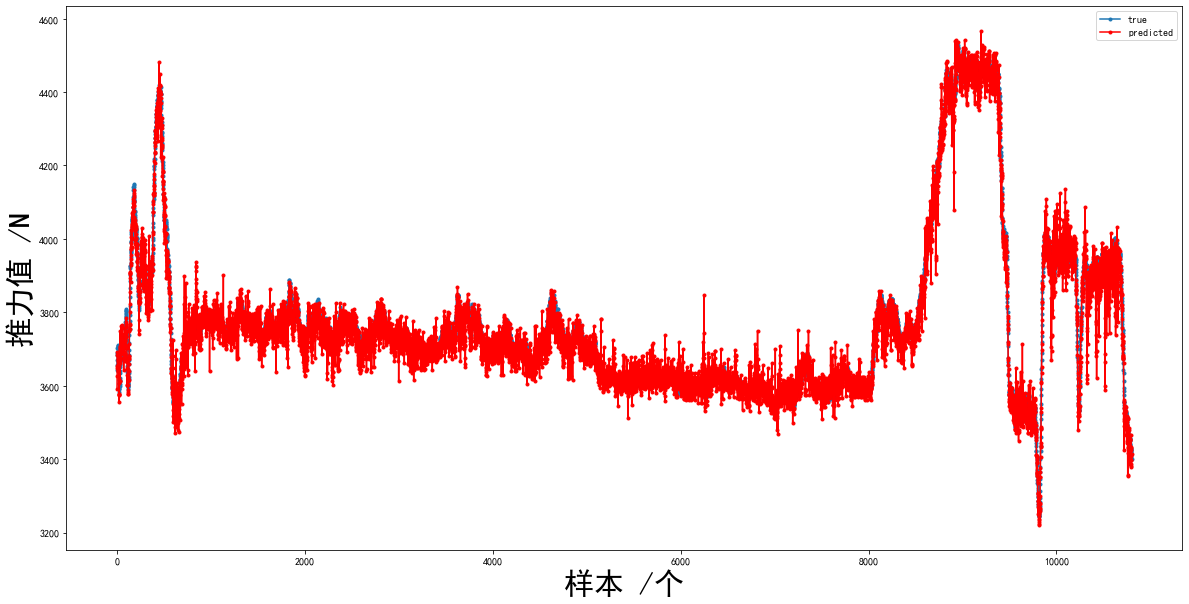

In [59]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot(predict_1[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend();